In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data as data

In [2]:
# 定义dataset
class my_Dataset(data.Dataset):#继承？
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [3]:
class TrafficDataset:
    def __init__(self, sensor_num=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = np.load('./traffic-flow/traffic.npz')['data']
        self.sensor_num = sensor_num
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=12,label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        len_train = int(self.data.shape[0] * train_por)
        len_val = int(self.data.shape[0] * val_por)
        len_test = int(self.data.shape[0] * test_por)
        train_seqs = self.data[:len_train]
        val_seqs = self.data[len_train:len_val+len_train]
        test_seqs = self.data[len_train+len_val:len_val+len_train+len_test]

        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            train_y.append(train_seqs[i+window_size, self.sensor_num, self.target].squeeze())

        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(val_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            val_y.append(val_seqs[i+window_size, self.sensor_num, self.target].squeeze())

        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            test_y.append(test_seqs[i+window_size, self.sensor_num, self.target].squeeze())
        
        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

In [4]:
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set()
batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

<ipython-input-3-72cc8f8dabf6>:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))


In [5]:
class My_legacyLSTM(nn.Module):
    def _init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_f = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_f = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        self.w_i = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_i = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        self.w_o = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_o = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

        self.w_c = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_c = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 需要初始化隐藏状态和细胞状态
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            forget_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_f) +
                                       torch.matmul(h, self.u_f) + self.b_f)
            # (batch_siz,hidden_size)
            input_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_i) +
                                      torch.matmul(h, self.u_i) + self.b_i)
            output_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_o) +
                                       torch.matmul(h, self.u_o) + self.b_o)
            # 这里可以看到各个门的运作方式。
            # 三个门均通过hadamard积作用在每一个维度上。
            c = forget_gate * c + input_gate * self.tanh(torch.matmul(x[:, i, :], self.w_c) +
                                                         torch.matmul(h, self.u_c) + self.b_c)
            h = output_gate * self.tanh(c)
            y_list.append(h)
        return torch.stack(y_list, dim=1), (h, c)

In [5]:
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
print(input_size, hidden_size, output_size)
seq_len = 12
lr = 0.00001
epochs = 20
loss_func = nn.MSELoss()
#my_legacylstm=My_legacyLSTM(input_size, hidden_size).to(device)
my_lstm = My_LSTM(input_size, hidden_size, output_size).to(device)
#optimizer1 = torch.optim.Adam(my_legacylstm.parameters(), lr)
optimizer2 = torch.optim.Adam(my_lstm.parameters(), lr)

3 64 1


In [10]:
from utils import *
train_loss_lst2, val_loss_lst2, \
    train_score_lst2, val_score_lst2, stop_epoch2 = train(my_lstm, train_loader, val_loader, test_loader,
                                                        loss_func, TrafficData.denormalize, optimizer2, epochs,
                                                        early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.1823, train rmse 489.0438, val loss 0.1446, val rmse 411.842256, time use 1.634s
*** epoch2, train loss 0.1415, train rmse 430.6918, val loss 0.1079, val rmse 350.136763, time use 1.600s
*** epoch3, train loss 0.1058, train rmse 372.1922, val loss 0.0775, val rmse 291.420766, time use 1.660s
*** epoch4, train loss 0.0762, train rmse 315.9761, val loss 0.0540, val rmse 242.726767, time use 1.565s
*** epoch5, train loss 0.0540, train rmse 265.7544, val loss 0.0370, val rmse 204.404659, time use 1.620s
*** epoch6, train loss 0.0383, train rmse 223.7924, val loss 0.0267, val rmse 177.894621, time use 1.546s
*** epoch7, train loss 0.0287, train rmse 194.1247, val loss 0.0213, val rmse 160.811892, time use 1.516s
*** epoch8, train loss 0.0237, train rmse 176.3122, val loss 0.0190, val rmse 150.534815, time use 1.502s
*** epoch9, train loss 0.0213, train rmse 167.1021, val loss 0.0181, val rmse 144.674383, time use 1.555s
*** epoch10, train loss 0.0200, train rmse 161

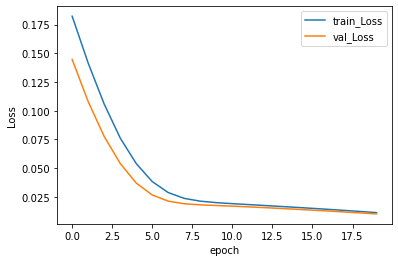

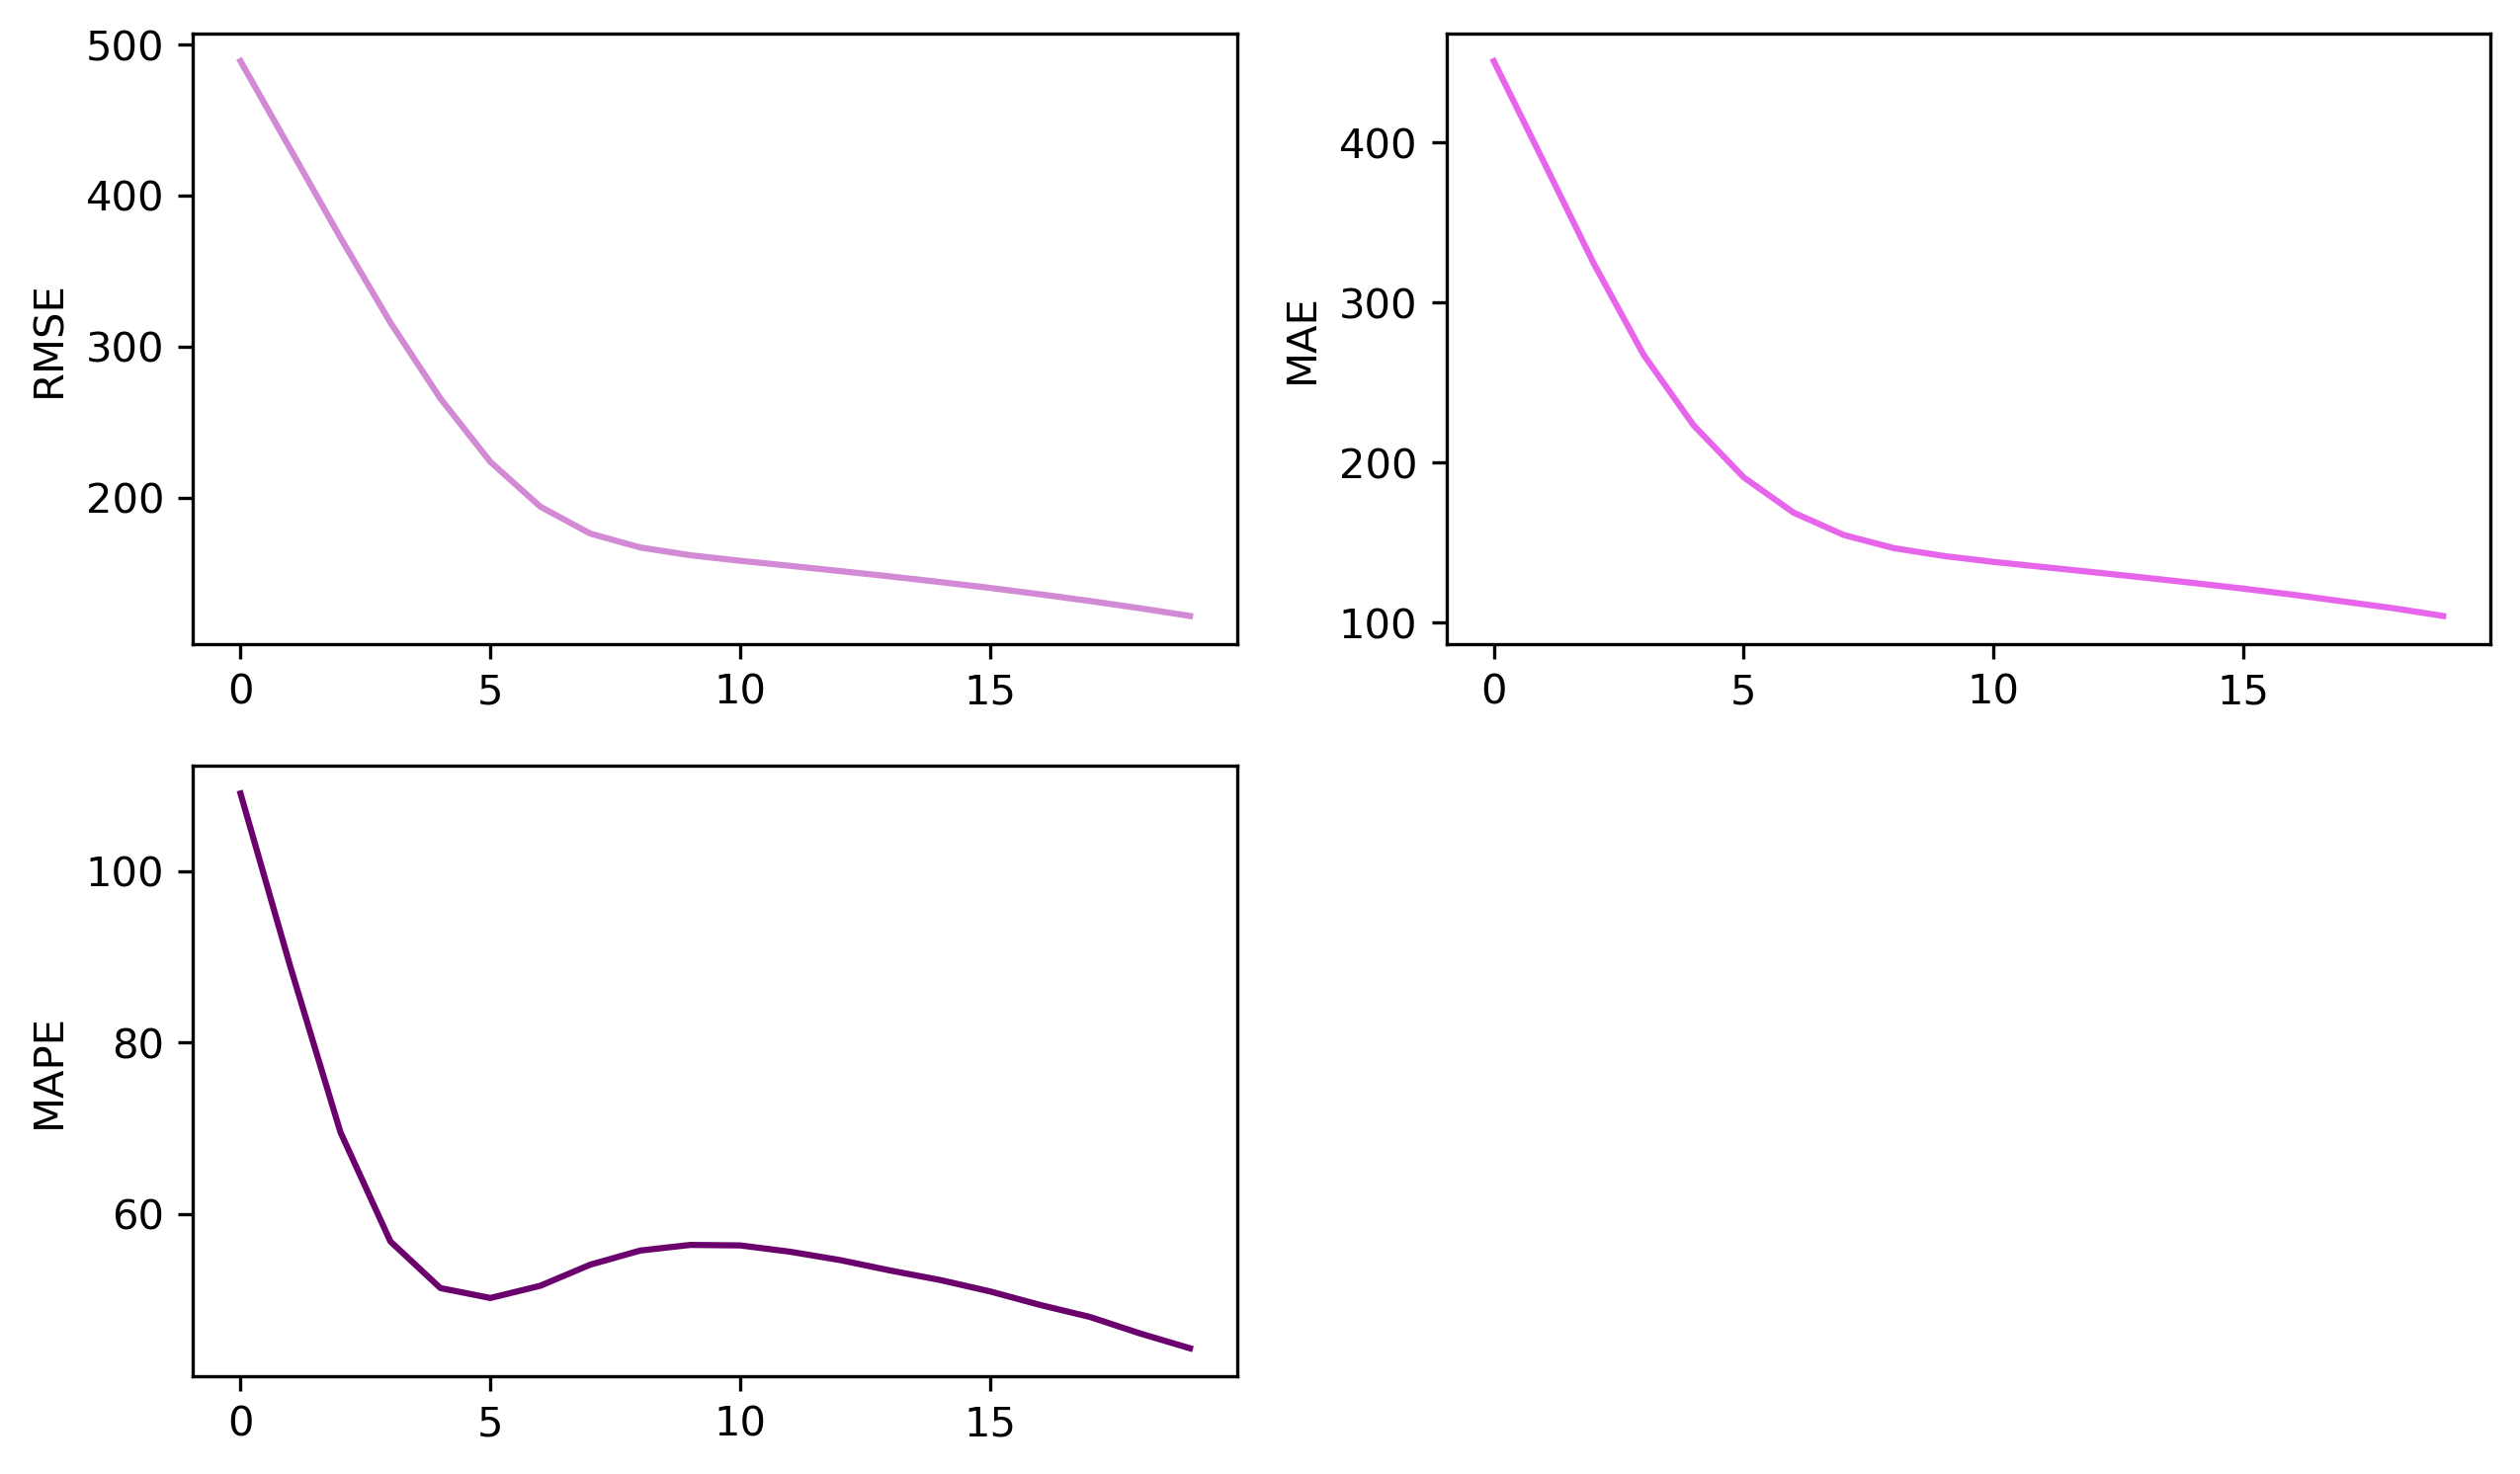

In [11]:
visualize(stop_epoch2, train_loss_lst2, val_loss_lst2, y_label='Loss')
plot_metric(train_score_lst2)